## making test plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
%matplotlib inline

In [2]:
from functions import ccplot

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
# plt.style.use(['science', 'notebook'])
plt.style.use('tableau-colorblind10')

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='BrBG', cmap_sequential='YlGnBu')

In [5]:
fsize = 15
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

# plt.style.use(style)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['legend.handlelength'] = 0.5

In [6]:
# making a new colomap -> tmap

n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu_r
lower = cmap(np.linspace(0, diff, n))
lower2 = cmap2(np.linspace(0, diff, n))
white = np.ones((1, 4))
white2 = np.ones((1, 4))
upper = cmap(np.linspace(1-diff, 1, n))
upper2 = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, upper))
colors2 = np.vstack((lower2, white2, upper2))
tmap = m.colors.LinearSegmentedColormap.from_list('map_white', colors)
tmap2 = m.colors.LinearSegmentedColormap.from_list('map_white', colors2)

## Import Data

In [7]:
mfdata_DIR = './data/GPM_lowres_data/*.nc'
gpm = xr.open_mfdataset(mfdata_DIR, chunks=dict(time=-1, lat=-1, lon=-1))

In [8]:
precip = gpm.precipCal.resample(time = '24H').sum() / 2

In [9]:
precip = precip.chunk(dict(time = -1, lat = -1, lon=-1))
precip

<xarray.DataArray 'precipCal' (time: 7700, lat: 161, lon: 161)>
dask.array<rechunk-merge, shape=(7700, 161, 161), dtype=float32, chunksize=(7700, 161, 161), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
  * lon      (lon) float64 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0

In [10]:
mfdata_DIR2 = './data/era_data/*.nc'
era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=-1, lat=-1, lon=-1))

In [11]:
era = era.sel(expver=1, drop=True)
era = era.transpose('time', 'latitude', 'longitude')
# era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})
era = era.rename({'longitude':'lon', 'latitude':'lat'})
era = era.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))
era

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 184800)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2021-06-30T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    mx2t     (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    mn2t     (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [12]:
mfdata_DIR3 = './data/era_pres_data/*.nc'
era_pres = xr.open_mfdataset(mfdata_DIR3, chunks=dict(time=-1, lat=-1, lon=-1))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era_pres = xr.open_mfdataset(mfdata_DIR3, chunks=dict(time=1000, lat=40, lon=40))

In [13]:
era_pres = era_pres.transpose('time', 'level', 'latitude', 'longitude')
# era_pres = era_pres.rename_dims({'longitude':'lon', 'latitude':'lat'})
era_pres = era_pres.rename({'longitude':'lon', 'latitude':'lat'})
era_pres = era_pres.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))
era_pres

,Array,Chunk
Bytes,517.50 GiB,2.02 GiB
Shape,"(184800, 29, 161, 161)","(720, 29, 161, 161)"
Count,1633 Tasks,400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,517.50 GiB,2.02 GiB
Shape,"(184800, 29, 161, 161)","(720, 29, 161, 161)"
Count,1633 Tasks,400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [14]:
mfdata_DIR4 = './data/era_data2/*.nc'
era2 = xr.open_mfdataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))
# era = xr.open_mfdataset(mfdata_DIR2, chunks=dict(time=1000, lat=40, lon=40), engine='netcdf4', parallel=True)
# era2 = xr.open_mfdataset(mfdata_DIR4, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era2 = xr.open_dataset(mfdata_DIR4, chunks=dict(time=-1, lat=-1, lon=-1))

In [15]:
# era2 = era2.sel(expver=1, drop=True)
era2 = era2.transpose('time', 'latitude', 'longitude')
# era2 = era2.rename_dims({'longitude':'lon', 'latitude':'lat'})
era2 = era2.rename({'longitude':'lon', 'latitude':'lat'})
era2 = era2.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))
era2

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 184800)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2021-06-30T23:00:00
Data variables:
    e        (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    vimd     (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-04 12:51:49 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [16]:
# t2m = era.t2m.sel(lat = 19, lon = 72).resample(time = '24H').mean()
# d2m = era.d2m.sel(lat = 19, lon = 72).resample(time = '24H').mean()
# vimd = (era2.vimd).sel(lat = 19, lon = 72).resample(time = '24H').mean()
# evap = (era2.e).sel(lat = 19, lon = 72).resample(time = '24H').mean()
# # u = (era.u10).resample(time = '24H').mean()
# # v = (era.v10).resample(time = '24H').mean()
pres = era_pres.sel(lat = 19, lon = 72).coords['level'],
temp = era_pres.t.sel(lat = 19, lon = 72).resample(time = '24H').mean()
omega = era_pres.w.sel(lat = 19, lon = 72).resample(time = '24H').mean()
q = era_pres.q.sel(lat = 19, lon = 72).resample(time = '24H').mean()

In [21]:
# ds_comb = xr.merge([precip.sel(lat=19, lon=72), t2m, d2m, vimd, evap])
# ds_comb2 = xr.merge([temp, q, omega])
ds_comb = xr.merge([precip.sel(lat=19, lon=72)])
ds_comb2 = xr.merge([temp, q, omega])

In [22]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [23]:
ds_comb_mon = xr.concat([list(ds_comb.groupby('time.month'))[i-1][1] for i in mon], dim='time')
ds_comb_mon2 = xr.concat([list(ds_comb2.groupby('time.month'))[i-1][1] for i in mon], dim='time')

In [24]:
ds_comb_mon = ds_comb_mon.chunk(dict(time = -1)).sortby('time.year')
ds_comb_mon2 = ds_comb_mon2.chunk(dict(time = -1)).sortby('time.year')

In [27]:
ds_comb_mon2

<xarray.Dataset>
Dimensions:  (time: 2592, level: 29)
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
    lon      float32 72.0
    lat      float32 19.0
  * level    (level) int32 50 70 100 125 150 175 ... 875 900 925 950 975 1000
Data variables:
    t        (time, level) float32 dask.array<chunksize=(2592, 29), meta=np.ndarray>
    q        (time, level) float32 dask.array<chunksize=(2592, 29), meta=np.ndarray>
    w        (time, level) float32 dask.array<chunksize=(2592, 29), meta=np.ndarray>

In [28]:
ds_comb_mon_loaded = ds_comb_mon.load()
ds_comb_mon2_loaded = ds_comb_mon2.load()

KeyboardInterrupt: 

In [ ]:
ds_comb_mon_loaded

In [ ]:
using_ds1 = ds_comb_mon_loaded.sel(time = "2010-08-29")

In [58]:
using_ds2 = ds_comb_mon2_loaded.sel(time = "2010-08-29")

In [30]:
precip = ds_comb_mon_loaded.precipCal
t2m = ds_comb_mon_loaded.t2m
d2m = ds_comb_mon_loaded.d2m
vimc = -ds_comb_mon_loaded.vimd
evap = ds_comb_mon_loaded.e

temp = ds_comb_mon2_loaded.t
q = ds_comb_mon2_loaded.q
omega = ds_comb_mon2_loaded.w

In [31]:
def get_qs(temp, pres):
    """
    Elemental Function to determine the precipitation estimate for each value of tempreature and omega at each grid point. (func to be used in starmap multithreading)
    ------------------
    Input :
        temp : temperature value at a grid point.
        omega_da : vertical velocity value at a grid point
    Output :
        qs : qs value at that grid point
    ------------------
    """
    a1 = 6.1114
    temp0 = 273.16
    a3w = 17.269
    a4w = 35.86
    a3i = 21.875
    a4i = 7.66

    # calculating saturation vapor pressure using temperature values
    if temp > temp0:
        a3 = a3w
        a4 = a4w
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    elif temp < temp0 - 23:
        a3 = a3i
        a4 = a4i
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    else:
        esw = a1 * np.exp(a3w * ((temp - temp0)/(temp - a4w)))
        esi = a1 * np.exp(a3i * ((temp - temp0)/(temp - a4i)))
        es = esi + ((esw - esi)*(((temp - (temp0 - 23))/23)**2))

    # get saturation specific humidity value
    epsilon = 0.622
    qs = (epsilon * es) / (pres - ((1 - epsilon)*es))
    return qs

In [32]:
def calc_qs(temp, pres):
    pres_range = len(pres)
    time_range = len(temp)
    qs = np.empty((time_range, pres_range))
    for i in range(time_range):
        for j in range(pres_range):
            qs[i, j] = get_qs(temp[i, j], pres[j])
        print(f"Completed time {i+1}/{time_range}", end='\r')
    return qs

In [36]:
# qs = calc_qs(t1.sel(lat=19, lon=72), pres)
qs = calc_qs(temp, pres[0])

KeyboardInterrupt: 

In [68]:
np.shape(qs)

(122, 29)

In [69]:
from scipy import integrate

In [70]:
# vert integral function (Simpson's method)
def vert_integ(x, y):
    int = integrate.simpson(y, x, even='avg')

    return int

# finite differnce methods to find derivative
def centered_diff(arr):
    arr_diff = np.empty(len(arr) - 2)
    for i in range((len(arr) - 2)):
        arr_diff[i] = arr[i+2] - arr[i]
    return arr_diff

def forward_diff(arr):
    arr_diff = np.diff(arr)
    return arr_diff

def backward_diff(arr):
    arr_diff = -(np.diff(arr[::-1])[::-1])
    return arr_diff

In [108]:
p_cdiff = centered_diff(pres[0])
p_fdiff = forward_diff(pres[0])
p_bdiff = backward_diff(pres[0])

pe = np.empty((len(qs)))
pw = np.empty((len(qs)))

for i in range(len(qs)):
    #
    qs_cdiff = centered_diff(qs[i])/(p_cdiff)
    qs_fdiff = forward_diff(qs[i])/(p_fdiff)
    qs_bdiff = backward_diff(qs[i])/(p_bdiff)
    #
    qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
    qs_diff = np.append(qs_diff, qs_bdiff[-1])
    # p_diff = np.insert(p_cdiff, 0, p_fdiff[0])
    # p_diff = np.append(p_diff, p_bdiff[-1])

    pe[i] = (-1/(9.806)) * vert_integ(pres[0], omega[i]*qs_diff) * 3600 * 24
    pw[i] = (1/(1000*9.806)) * vert_integ(pres[0], q[i]) * 3600 * 24

# p_cdiff = centered_diff(pres[0])
# p_fdiff = forward_diff(pres[0])
# p_bdiff = backward_diff(pres[0])
# #
# pe = np.empty(len(temporary_precip_indx))
# i = 0
# for t in temporary_precip_indx:
#     qs_cdiff = centered_diff(qs[t])/(p_cdiff)
#     qs_fdiff = forward_diff(qs[t])/(p_fdiff)
#     qs_bdiff = backward_diff(qs[t])/(p_bdiff)

#     qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
#     qs_diff = np.append(qs_diff, qs_bdiff[-1])
#     # p_diff = np.insert(p_cdiff, 0, p_fdiff[0])
#     # p_diff = np.append(p_diff, p_bdiff[-1])

#     pe[i] = (-100/9.806) * vert_integ(pres[0], (w1[t]*qs_diff))
#     i = i +1
# print("Done")

In [130]:
p_climate = precip.group

In [132]:
p_climate

16.897457

In [109]:
import pandas as pd

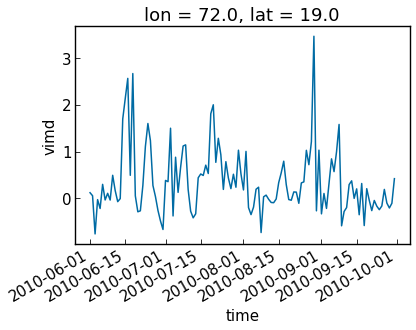

In [128]:
vimc.plot()

(array([14761., 14775., 14791., 14805., 14822., 14836., 14853., 14867.,
        14883.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

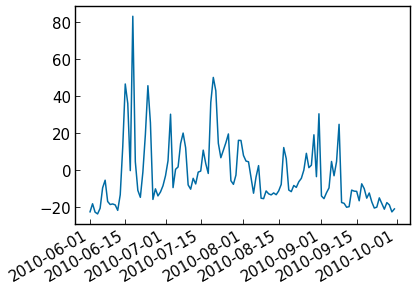

In [133]:
plt.plot(pd.date_range("2010-06-01", "2010-09-30", freq='1D'), pe-p_climate)
plt.xticks(rotation=30, ha='right')

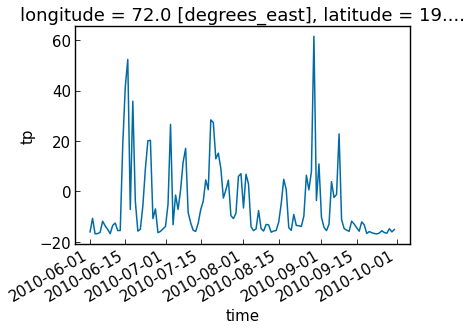

In [134]:
(era_precip.tp*1000 - p_climate).plot()

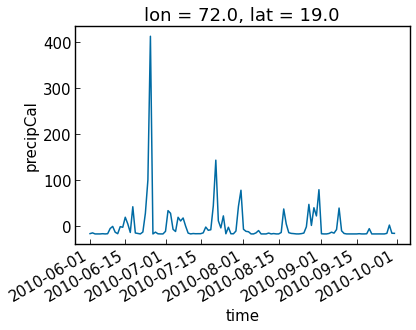

In [135]:
(precip - p_climate).plot()

(array([14761., 14775., 14791., 14805., 14822., 14836., 14853., 14867.,
        14883.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

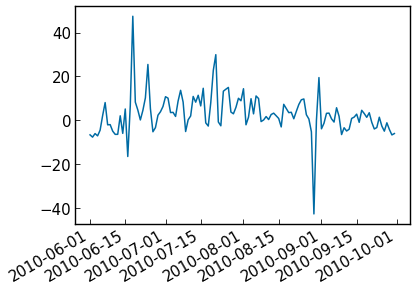

In [123]:
plt.plot(pd.date_range("2010-06-01", "2010-09-30", freq='1D'), pe-(era_precip.tp*1000))
plt.xticks(rotation=30, ha='right')

(array([14761., 14775., 14791., 14805., 14822., 14836., 14853., 14867.,
        14883.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

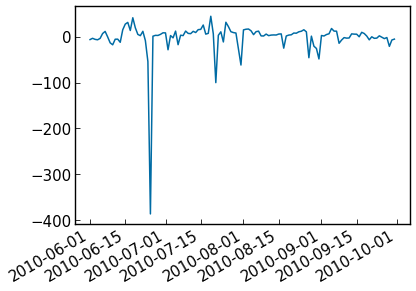

In [118]:
plt.plot(pd.date_range("2010-06-01", "2010-09-30", freq='1D'), pe-precip)
plt.xticks(rotation=30, ha='right')

In [81]:
era_precip = xr.open_dataset('/home/nkv/Downloads/era_precip.nc')
era_precip

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 161, time: 2928)
Coordinates:
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2010-06-01 ... 2010-09-30T23:00:00
Data variables:
    mcpr       (time, latitude, longitude) float32 ...
    mlspr      (time, latitude, longitude) float32 ...
    mtpr       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-25 13:19:23 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [82]:
era_precip = era_precip.sel(latitude = 19, longitude = 72)

In [83]:
era_precip = era_precip.resample(time = '24H').sum()

In [4]:
gpm_daily = xr.open_mfdataset('/home/nkv/Documents/aditya/gpm_2010_daily/*.nc4')

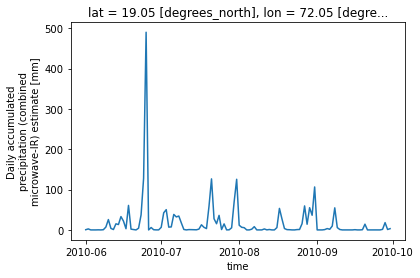

In [8]:
gpm_daily.precipitationCal.sel(lat = 19.05, lon = 72.05).plot()

## testing quantreg

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [2]:
rng = np.random.RandomState(42)

In [3]:
x = np.linspace(0, 10, 2000)
X = x[:, np.newaxis]

In [4]:
X.shape

(2000, 1)

In [5]:
y_true_mean = 10 + 0.5 * x

In [6]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

In [7]:
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

In [8]:
y_pareto.shape

(2000,)

In [9]:
qr = QuantileRegressor(quantile=0.99, alpha=0)

In [10]:
qr5 = QuantileRegressor(quantile=0.50, alpha=0)

In [11]:
y_pred = qr.fit(X, y_normal).predict(X)

In [21]:
y_pred5 = qr5.fit(X, y_normal).predict(X)

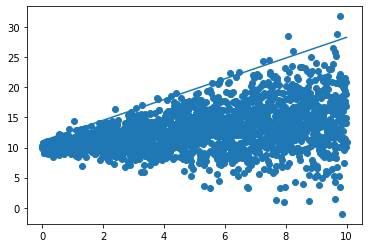

In [12]:
plt.plot(x, y_pred)
# plt.plot(x, y_pred5)
plt.scatter(x, y_normal)